## **Nonlinear Control: Inverse Dynamics, Robust and Adaptive control**


In [2]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.alpha'] = 0.7


### **Vessel on the River**

Consider a folowing vessel on the river:

<p align="center">
<img src="https://blog.arduino.cc/wp-content/uploads/2021/11/DawveRf-1024x683.jpeg" alt="drawing" width="35%" style="margin:auto"/>
</p>


where $x, y$ are cartesian coordinates w.r.t global frame, $\theta$ heading angle, $0<\delta<\delta_{max}$ river flow $v_\tau, v_n, \omega$ are linear and angular velocity of vessel w.r.t. local coordinate frame.

<p align="center">
<img src="https://drive.google.com/uc?id=14Y5dheMte0hTe7MGCLE143wXmgJx96NR" alt="drawing" hspace="300px" width="50%" style="margin:auto"/>
</p>

With differential kinematics described as follows:

$$
\dot{\mathbf{x}} =
\begin{bmatrix}
\dot{x}
\\
\dot{y}
\\
\dot{\theta}
\end{bmatrix}
=
\begin{bmatrix}
 \cos \theta & -\sin \theta & 0\\
 \sin \theta & \cos \theta & 0\\
 0 & 0 & 1\\
\end{bmatrix}
\begin{bmatrix}
v_\tau
\\
v_n
\\
\omega
\end{bmatrix}
+
\begin{bmatrix}
\delta \\
0 \\
0\\
\end{bmatrix}
= \mathbf{R}(\theta)\mathbf{u} + \boldsymbol{\delta}(t)
$$


---

The goal is to design feedback controller $\mathbf{u}(\mathbf{x})$ to regulate and track given trajectories even in the presense of river flow:

- Inverse dynamics:
  - Assuming for now that river flow $\delta = 0$, propose the inverse dynamics control that regulate vessel to the desired state
  - Modify controller to track time varying trajectories, take for instance $x_d = 10\cos t/5, y_d = 10\sin t/5, \theta_d = \pi/2 + t/5$
  - Tune the controller such that it will use less controll effort in the $n$ direction.
  - Simulate the response for both tracking and regulation.


In [3]:
import matplotlib.pyplot as plt


def show(solution, xd, dxd, t):
    f, axes = plt.subplots(3, 2, figsize=(7, 14))
    axes[0, 0].plot(t, solution[:, 0], label='sim')
    axes[0, 0].plot(t, xd(t)[0], label='desired')
    axes[0, 0].grid()
    axes[0, 0].set_xlabel('t, (s)')
    axes[0, 0].set_ylabel('X, (m)')
    axes[0, 0].legend()

    axes[0, 1].plot(t, solution[:, 0] - xd(t)[0], label=r'error $x - x^{*}$')
    axes[0, 1].grid()
    axes[0, 1].set_xlabel('t, (s)')
    axes[0, 1].legend()

    axes[1, 0].plot(t, solution[:, 1], label='sim')
    axes[1, 0].plot(t, xd(t)[1], label='desired')
    axes[1, 0].grid()
    axes[1, 0].set_xlabel('t, (s)')
    axes[1, 0].set_ylabel('Y, (m)')
    axes[1, 0].legend()

    axes[1, 1].plot(t, solution[:, 1] - xd(t)[1], label=r'error $y - y^{*}$')
    axes[1, 1].grid()
    axes[1, 1].set_xlabel('t, (s)')
    axes[1, 1].legend()

    axes[2, 0].plot(t, solution[:, 2], label='sim')
    axes[2, 0].plot(t, xd(t)[2], label='desired')
    axes[2, 0].grid()
    axes[2, 0].set_xlabel('t, (s)')
    axes[2, 0].set_ylabel(r'$\Theta$, (rad)')
    axes[2, 0].legend()

    axes[2, 1].plot(t, solution[:, 2] - xd(t)[2],
                    label=r'error $\theta - \theta^{*}$')
    axes[2, 1].grid()
    axes[2, 1].set_xlabel('t, (s)')
    axes[2, 1].legend()


In [4]:
import numpy as np
from scipy.integrate import odeint


def x_des(t): return np.array([
    10 * np.cos(t / 5),
    10 * np.sin(t / 5),
    np.pi / 2 + t / 5,
])


def dx_des(t): return np.array([
    -2 * np.sin(t / 5),
    2 * np.cos(t / 5),
    1 / 5 * np.ones_like(t),
])


# x - [x, y, theta]


def R(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1],
    ])


def model(x, t, u, f):
    u_t = u(t, x)
    return R(x[2]) @ u_t + f(t)


def simulate(x0, control, flow, time):
    sol = odeint(model, x0, time, args=(control, flow,))

    return sol


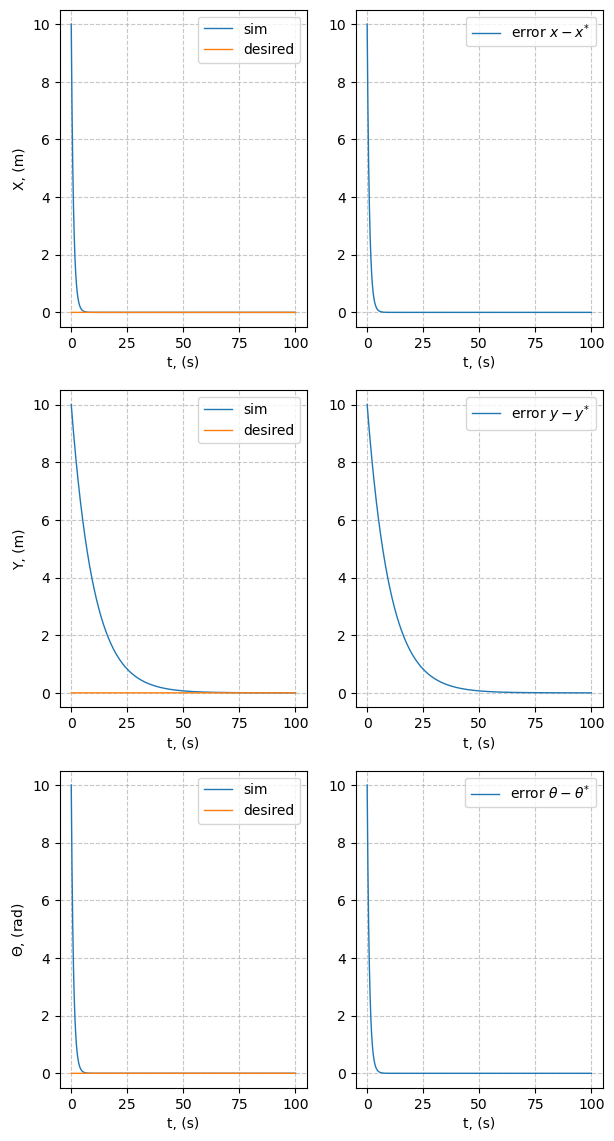

In [5]:
# regulation

x0 = np.array([10, 10, 10])
t = np.linspace(0, 100, 100000)


def control(t, x):
    kp = np.array([
        [1, 0, 0],
        [0, 0.1, 0],    # lower normal component for less effort in v_n
        [0, 0, 1],
    ])

    v = kp @ (- x)

    return R(x[2]).T @ v


def flow(t):
    return np.array([0, 0, 0])


solution = simulate(x0, control, flow, t)

show(solution, lambda t: np.array([t * 0, t * 0, t * 0]), lambda t: np.array([t * 0, t * 0, t * 0]), t)


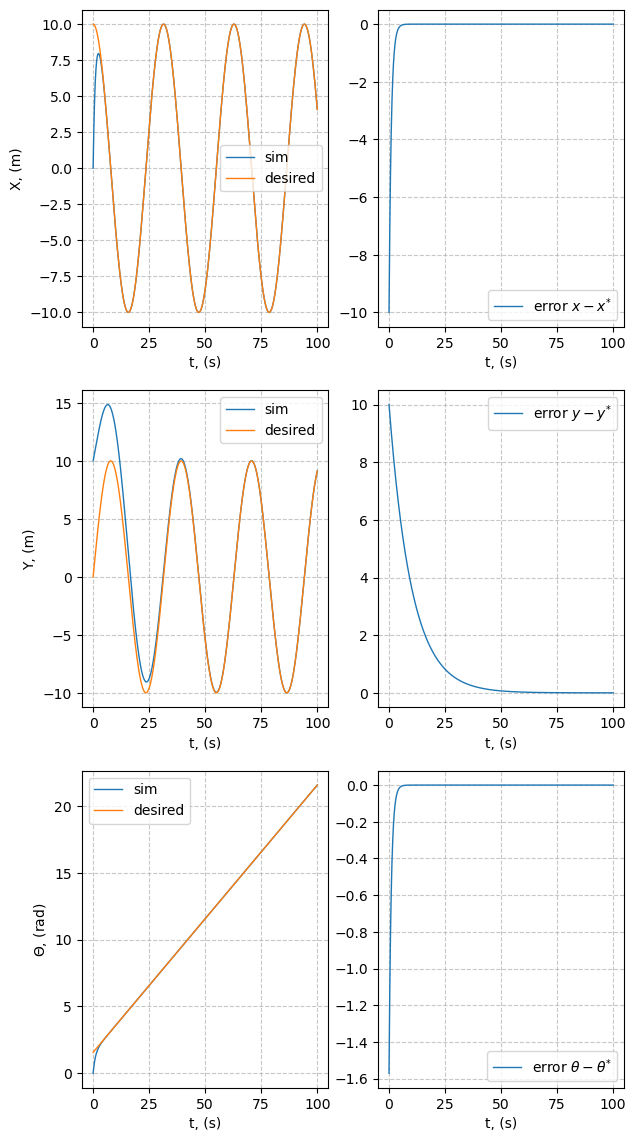

In [6]:
# tracking

x0 = np.array([0, 10, 0])
t = np.linspace(0, 100, 100000)


def control(t, x):
    kp = np.array([
        [1, 0, 0],
        [0, 0.1, 0],    # lower normal component for less effort in v_n
        [0, 0, 1],
    ])

    v = dx_des(t) + kp @ (x_des(t) - x)

    return R(x[2]).T @ v


def flow(t):
    return np.array([0, 0, 0])


solution = simulate(x0, control, flow, t)

show(solution, x_des, dx_des, t)


- Flow disturbance and sliding mode:
  - Suppose now that there is disturbance due to river flow $\delta < 1$ (as example you may take $\delta(t) = 2/3+\sin(0.1t)/3$, introduce this to the dynamics and study response of inverse dynamics controller.
  - Use sliding mode technique to propose the modification of the inverse dynamics controller that will eleminate the effect of the disturbance. Simulate the response.
  - Tune controller such that convergence to the boundary layer given by $\|\tilde{\mathbf{x}}\| < 0.1$ is achieved


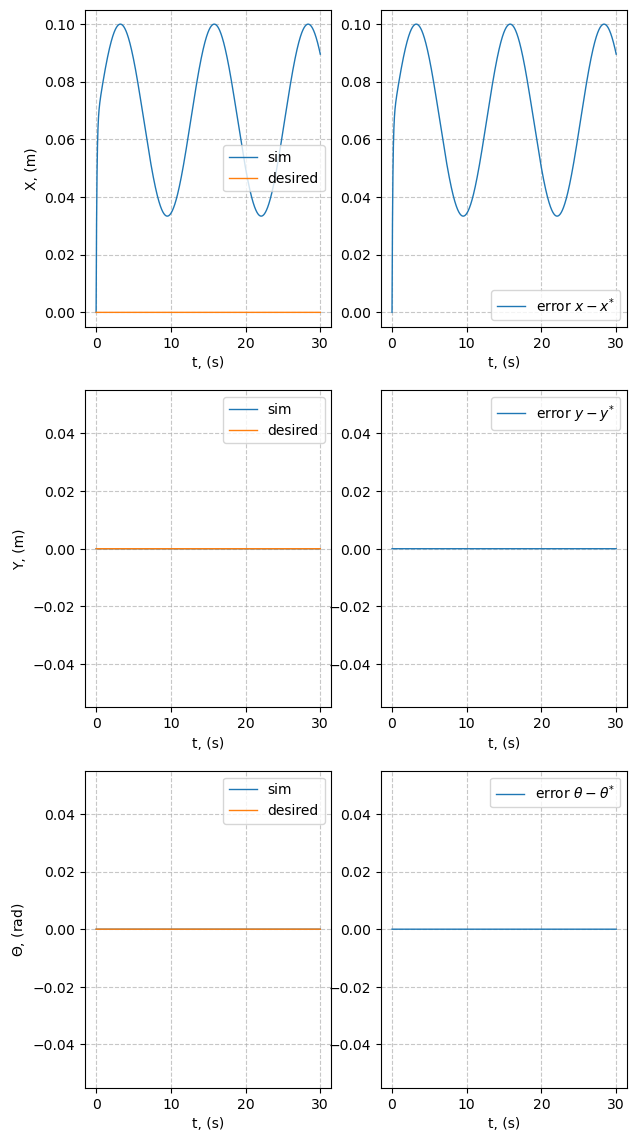

In [7]:
x0 = np.array([0, 0, 0])
t = np.linspace(0, 30, 30000)


def control(t, x):
    kp = np.array([
        [10, 0, 0],
        [0, 10, 0],
        [0, 0, 10],
    ])

    v = + dx_des(t) + kp @ (x_des(t) - x)

    return R(x[2]).T @ v


def flow(t):
    return np.array([2/3 + np.sin(0.5 * t) / 3, 0, 0])


def x_des(t):
    return np.array([t * 0, t * 0, t * 0])


def dx_des(t):
    return np.array([t * 0, t * 0, t * 0])


solution = simulate(x0, control, flow, t)

show(solution, x_des, dx_des, t)


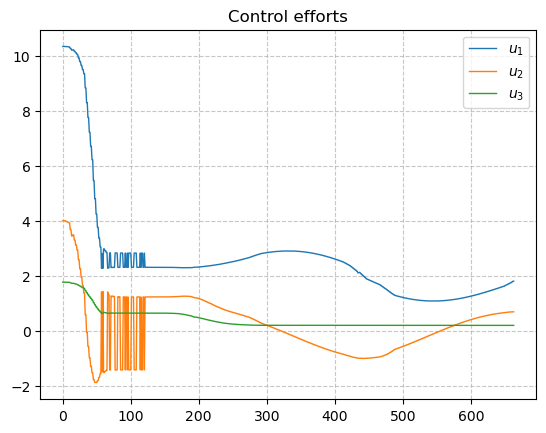

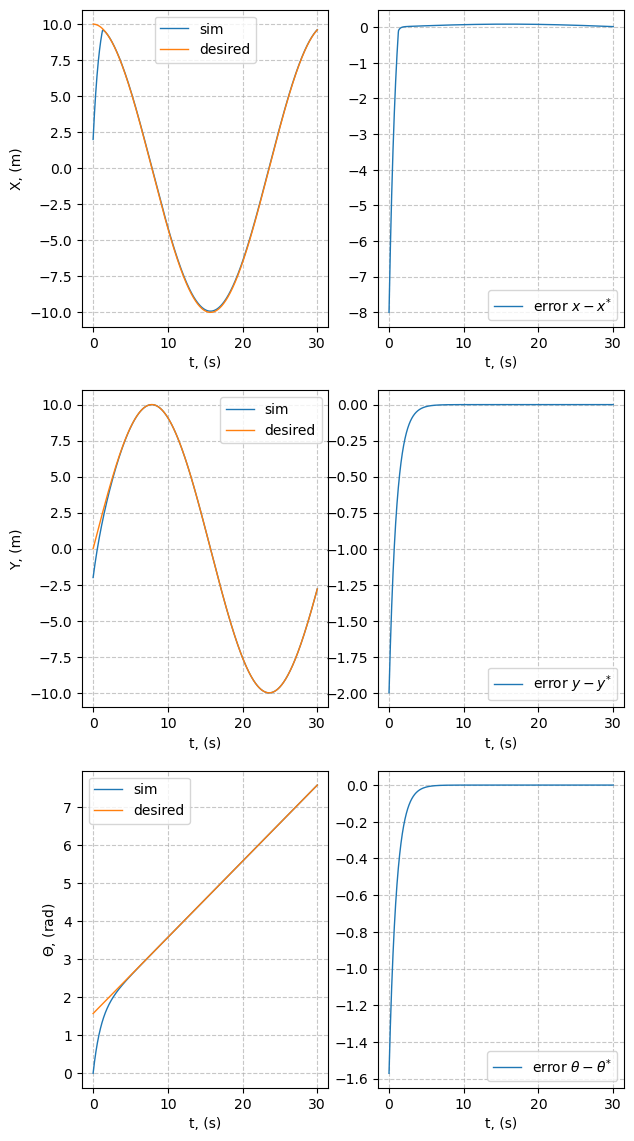

In [21]:
x0 = np.array([2, -2, 0])
t = np.linspace(0, 30, 30000)


def x_des(t): return np.array([
    10 * np.cos(t / 5),
    10 * np.sin(t / 5),
    np.pi / 2 + t / 5,
])


def dx_des(t): return np.array([
    -2 * np.sin(t / 5),
    2 * np.cos(t / 5),
    1 / 5 * np.ones_like(t),
])

v_history = []

def control(t, x):
    kp = np.array([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
    ])

    k = 3

    # define surface
    s = np.array([
        x_des(t)[0] - x[0],
        0,
        0
    ])
    if np.linalg.norm(s) > 0.1:
        u_s = k * np.sign(s) + np.array([- 2 / 3, 0, 0])
    else:
        u_s = k * np.tanh(s) + np.array([- 2 / 3, 0, 0])

    u_hat = dx_des(t) + kp @ (x_des(t) - x)

    v = u_hat + u_s
    v_history.append(R(x[2]).T @ v)

    return R(x[2]).T @ v


def flow(t):
    return np.array([2/3 + np.sin(0.1 * t) / 3, 0, 0])


solution = simulate(x0, control, flow, t)

plt.figure()
plt.title('Control efforts')
plt.plot(v_history, label=[r'$u_1$', r'$u_2$', r'$u_3$'])
plt.legend()
plt.grid()

show(solution, x_des, dx_des, t)


- Adaptive control:
  - Assume now that bounds on the river flow is not known in advance, propose the adaptive control that will estimate the unknown disturbance while tracking the same trajectories
  - Simulate response and show the convergence of tracking error and flow estimate $\hat{\delta}$

---


In [9]:
x0 = np.array([2, -2, 0, 0])
t = np.linspace(0, 20, 20000)


def model_adaptive(x, t, u, f):
    u_t = u(t, x)
    u_model_t, dp_t = u_t[:3], u_t[3]
    s = R(x[2]) @ u_model_t + f(t)
    return np.array([*s, dp_t])


def x_des(t): return np.array([
    10 * np.cos(t / 5),
    10 * np.sin(t / 5),
    np.pi / 2 + t / 5,
])


def dx_des(t): return np.array([
    -2 * np.sin(t / 5),
    2 * np.cos(t / 5),
    1 / 5 * np.ones_like(t),
])


def control(t, x):
    x, p = x[:3], x[3]

    gamma = 0.2

    kp = np.array([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
    ])

    # k = 2
    # # define surface
    # s = np.array([
    #     x_des(t)[0] - x[0],
    #     0,
    #     0
    # ])
    # if np.linalg.norm(s) > 0.1:
    #     u_s = k * np.sign(s) + np.array([- 2 / 3, 0, 0])
    # else:
    #     u_s = k * np.tanh(s) + np.array([- 2 / 3, 0, 0])

    u_hat = dx_des(t) + kp @ (x_des(t) - x)

    # control
    v = u_hat - np.array([p, 0, 0])  # + u_s

    # adaptation law
    dp = - 1 / gamma * (x_des(t)[0] - x[0])

    # linearizing control
    res = R(x[2]).T @ v
    return np.array([*res, dp])


def flow(t):
    return np.array([2/3 + np.sin(0.1 * t) / 3, 0 * t, 0 * t])


solution = odeint(model_adaptive, x0, t, args=(control, flow))

solution.shape


(20000, 4)

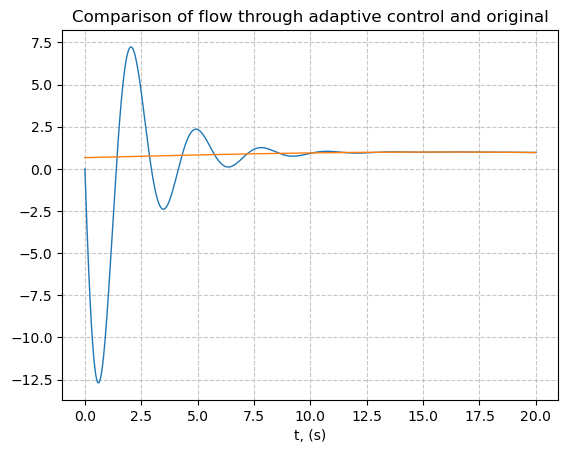

In [10]:
flow_computed = solution[:, 3]

plt.title('Comparison of flow through adaptive control and original')
plt.plot(t, flow_computed, label='computed flow')
plt.plot(t, flow(t)[0], label='original flow')
plt.xlabel('t, (s)')
plt.grid()


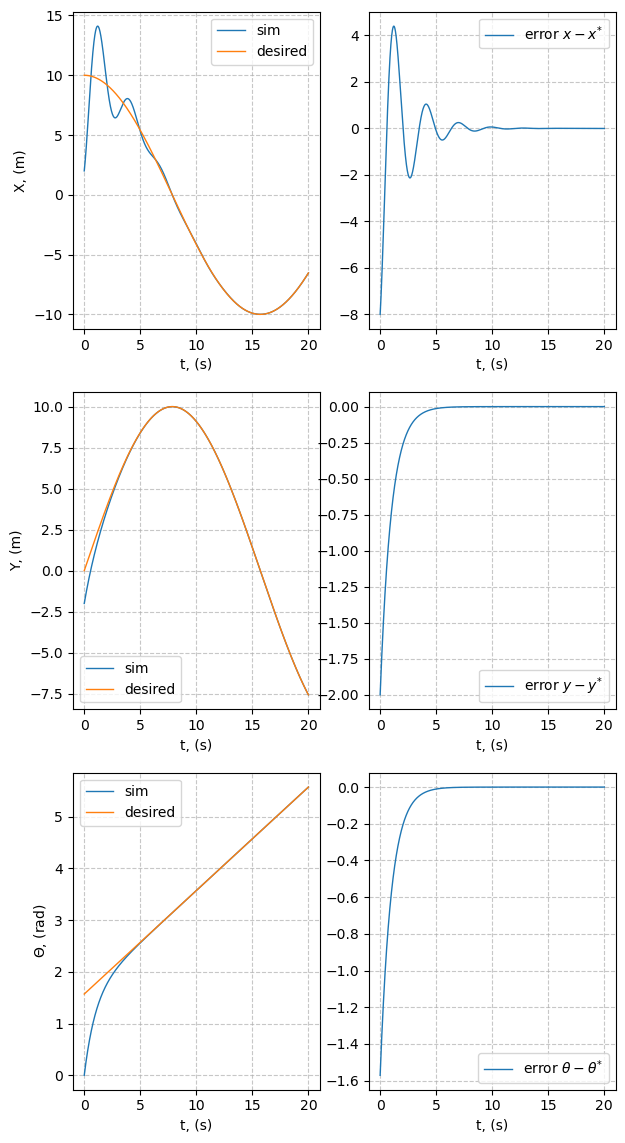

In [11]:
show(solution[:, :3], x_des, dx_des, t)


**Overactuated vessel and Input mapping**


In practice the actual inputs are not the linear and angular velocities of the cessel. For instance consider the case of four thrusters installed on the vessel such that the mapping between thrusters and vessel velocity is given by:

$$
\mathbf{u} =
\begin{bmatrix}
v_\tau
\\
v_n
\\
\omega
\end{bmatrix}
=
\begin{bmatrix}
 -\cos \phi & -\cos \phi & 1 & 1\\
 \sin \phi & \sin \phi & 0 & 0\\
 -\ell_2\cos \phi  + \ell_1\sin \phi &  \ell_2\cos \phi  - \ell_1\sin \phi & -\ell & \ell\\
\end{bmatrix}
\begin{bmatrix}
v_1
\\
v_2
\\
v_3
\\
v_4
\end{bmatrix}
= \mathbf{H}(\phi)\mathbf{u}^*
$$

- Modify system dynamics, and either adaptive or robust controller and find appropriate $\mathbf{u}^*$ such that boat will have the same response as if you control $\mathbf{u}$ directly.
- Assume now that the $v_1, v_2$ are twice less powerfull then $v_3, v_4$. How would you modify your controller to tackle this
- Introduce the trajectory planner to your controller such that vessel will favour the velocity along the $\tau$ direction. (read notes below)


In [12]:
import sympy

l1, l2, l, phi = sympy.symbols('l1 l2 l phi')

Hs = sympy.Matrix([
    [-sympy.cos(phi), -sympy.cos(phi), 1, 1],
    [sympy.sin(phi), sympy.sin(phi), 0, 0],
    [-l2 * sympy.cos(phi) + l1 * sympy.sin(phi), l2 * sympy.cos(phi) - l1 * sympy.sin(phi), -l, l]
])

Hs

Matrix([
[                -cos(phi),                  -cos(phi),  1, 1],
[                 sin(phi),                   sin(phi),  0, 0],
[l1*sin(phi) - l2*cos(phi), -l1*sin(phi) + l2*cos(phi), -l, l]])

In [13]:
Hs.nullspace()

[Matrix([
 [-l/(l1*sin(phi) - l2*cos(phi))],
 [ l/(l1*sin(phi) - l2*cos(phi))],
 [                            -1],
 [                             1]])]

# Chosen interpretation of control mapping 
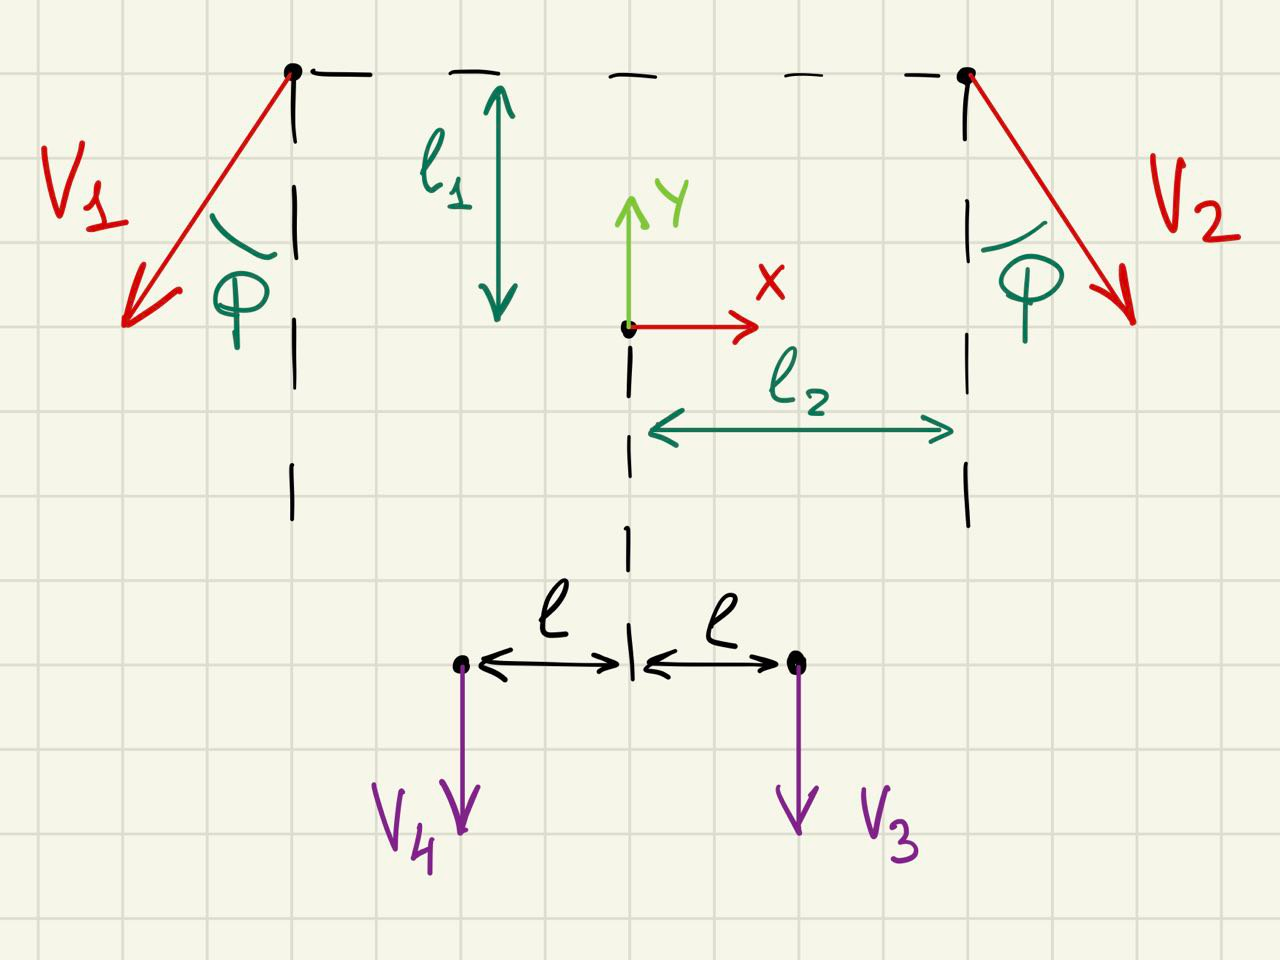

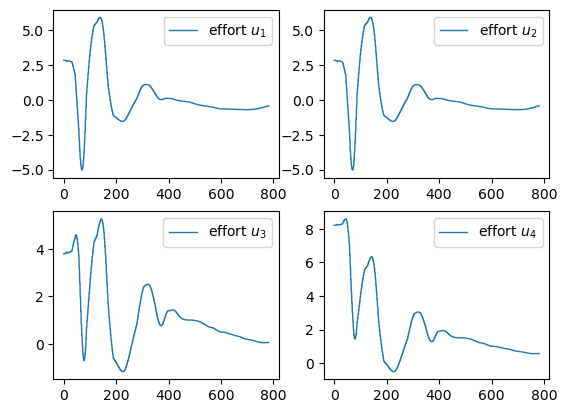

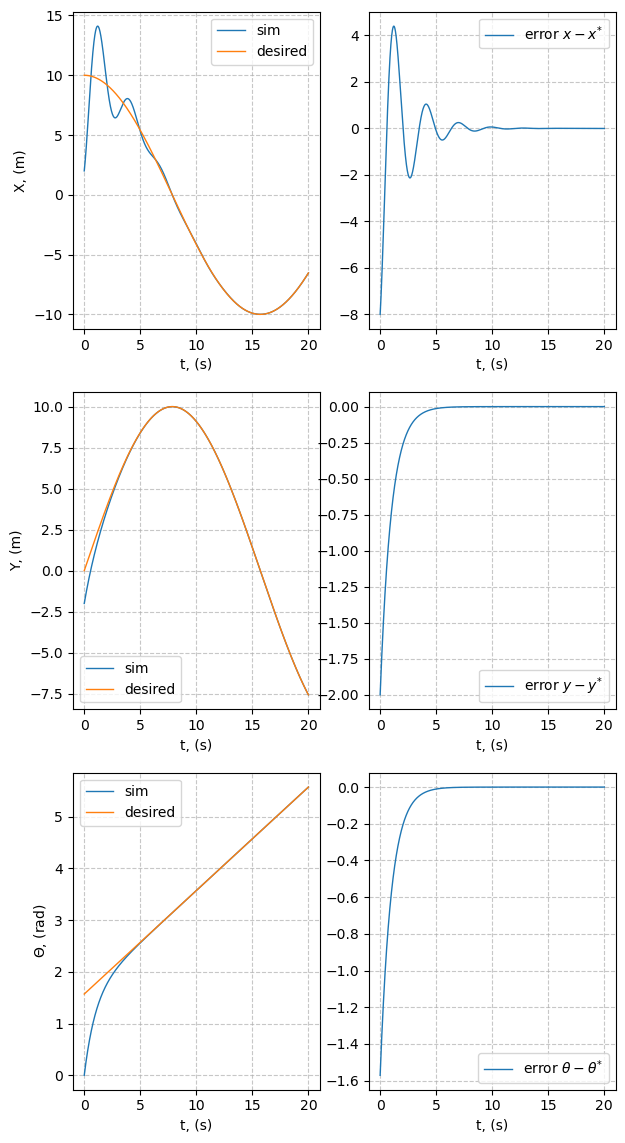

In [14]:
x0 = np.array([2, -2, 0, 0])
t = np.linspace(0, 20, 20000)


def model_adaptive(x, t, u, f):
    u_t = u(t, x)
    u_model_t, dp_t = u_t[:3], u_t[3]
    s = R(x[2]) @ u_model_t + f(t)
    # print(s.shape)
    return np.array([*s, dp_t])


def x_des(t): return np.array([
    10 * np.cos(t / 5),
    10 * np.sin(t / 5),
    np.pi / 2 + t / 5,
])


def dx_des(t): return np.array([
    -2 * np.sin(t / 5),
    2 * np.cos(t / 5),
    1 / 5 * np.ones_like(t),
])


def H(phi=np.pi / 4):
    l1, l2, l = 0.4, 0.4, 0.4
    c, s = np.cos(phi), np.sin(phi)
    return np.array([
        [-c, -c, 1, 1],
        [s, s, 0, 0],
        [-l2 * c + l1 * s, l2 * c - l1 * s, -l, l],
    ])


u14_history = []


def control(t, x):
    x, p = x[:3], x[3]

    gamma = 0.2

    kp = np.array([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
    ])

    u_hat = dx_des(t) + kp @ (x_des(t) - x)

    # control
    v = u_hat - np.array([p, 0, 0])  # + u_s

    # adaptation law
    dp = - 1 / gamma * (x_des(t)[0] - x[0])

    # linearizing control
    res = R(x[2]).T @ v

    # mapping back from u1-3 to u1-4
    u14_history.append(np.linalg.pinv(H()) @ res)

    return np.array([*res, dp])


def flow(t):
    return np.array([2/3 + np.sin(0.1 * t) / 3, 0 * t, 0 * t])


solution = odeint(model_adaptive, x0, t, args=(control, flow))

f, axes = plt.subplots(2, 2)
u14_history = np.array(u14_history)
axes[0, 0].plot(u14_history[:, 0], label=r"effort $u_1$")
axes[0, 0].legend()
axes[0, 1].plot(u14_history[:, 1], label=r"effort $u_2$")
axes[0, 1].legend()
axes[1, 0].plot(u14_history[:, 2], label=r"effort $u_3$")
axes[1, 0].legend()
axes[1, 1].plot(u14_history[:, 3], label=r"effort $u_4$")
axes[1, 1].legend()

show(solution[:, :3], x_des, dx_des, t)


## u3, u4 are twice more powerful than u1, u2, update

(783, 4)


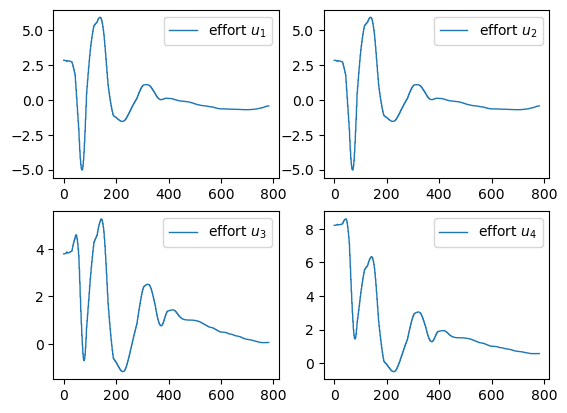

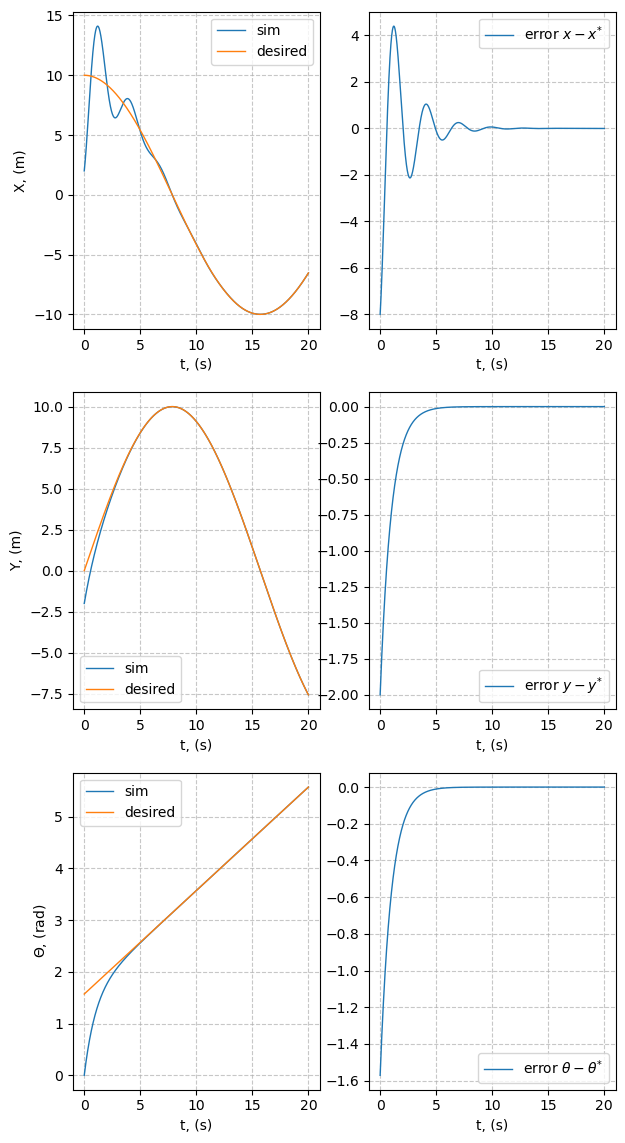

In [15]:
x0 = np.array([2, -2, 0, 0])
t = np.linspace(0, 20, 20000)


def model_adaptive(x, t, u, f):
    u_t = u(t, x)
    u_model_t, dp_t = u_t[:3], u_t[3]
    s = R(x[2]) @ u_model_t + f(t)
    # print(s.shape)
    return np.array([*s, dp_t])


def x_des(t): return np.array([
    10 * np.cos(t / 5),
    10 * np.sin(t / 5),
    np.pi / 2 + t / 5,
])


def dx_des(t): return np.array([
    -2 * np.sin(t / 5),
    2 * np.cos(t / 5),
    1 / 5 * np.ones_like(t),
])

def H(phi=np.pi / 4):
    l1, l2, l = 0.4, 0.4, 0.4
    c, s = np.cos(phi), np.sin(phi)
    return np.array([
        [-c, -c, 1, 1],
        [s, s, 0, 0],
        [-l2 * c + l1 * s, l2 * c - l1 * s, -l, l],
    ])


u14_history2 = []

def solve_control(u13, H):
    # function solves control from u1, u2, u3 to u1, u2, u3, u4

    import cvxpy as cp

    x = cp.Variable(4)
    objective = cp.Maximize(np.array([1, 1, 2, 2]) @ x)
    constraint = [H @ x == u13]
    prob = cp.Problem(objective, constraint)

    result = prob.solve()
    if x.value is None:
        print(result)
        print("Error")
        print(u13, np.linalg.pinv(H) @ u13)
        return np.array([0, 0, 0, 0])
    return np.array(x.value)


def control(t, x):
    x, p = x[:3], x[3]

    gamma = 0.2

    kp = np.array([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
    ])

    u_hat = dx_des(t) + kp @ (x_des(t) - x)

    # control
    v = u_hat - np.array([p, 0, 0])  # + u_s

    # adaptation law
    dp = - 1 / gamma * (x_des(t)[0] - x[0])

    # linearizing control
    res = R(x[2]).T @ v

    # mapping back from u1-3 to u1-4
    # u14_history.append(np.linalg.pinv(H()) @ res)
    u14_history2.append(solve_control(res, H()))

    return np.array([*res, dp])


def flow(t):
    return np.array([2/3 + np.sin(0.1 * t) / 3, 0 * t, 0 * t])


solution = odeint(model_adaptive, x0, t, args=(control, flow))

f, axes = plt.subplots(2, 2)
u14_history2 = np.array(u14_history2)
print(u14_history2.shape)
axes[0, 0].plot(u14_history2[:, 0], label=r"effort $u_1$")
axes[0, 0].legend()
axes[0, 1].plot(u14_history2[:, 1], label=r"effort $u_2$")
axes[0, 1].legend()
axes[1, 0].plot(u14_history2[:, 2], label=r"effort $u_3$")
axes[1, 0].legend()
axes[1, 1].plot(u14_history2[:, 3], label=r"effort $u_4$")
axes[1, 1].legend()

show(solution[:, :3], x_des, dx_des, t)


## Compare efforts

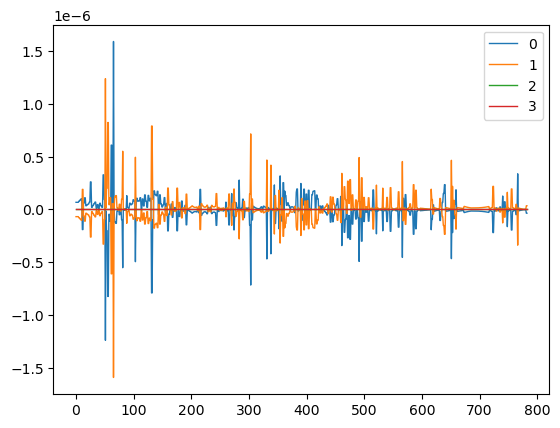

In [16]:
plt.plot(u14_history - u14_history2, label=[0, 1, 2, 3])
plt.legend()

(783, 4)


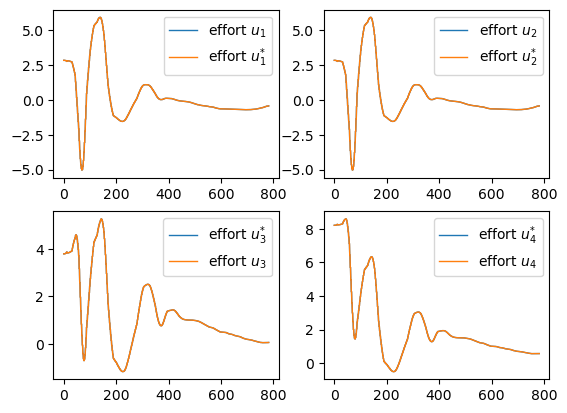

In [17]:
f, axes = plt.subplots(2, 2)
u14_history2 = np.array(u14_history2)
print(u14_history2.shape)
axes[0, 0].plot(u14_history[:, 0], label=r"effort $u_1$")
axes[0, 0].plot(u14_history2[:, 0], label=r"effort $u^{*}_1$")
axes[0, 0].legend()

axes[0, 1].plot(u14_history[:, 1], label=r"effort $u_2$")
axes[0, 1].plot(u14_history2[:, 1], label=r"effort $u^{*}_2$")
axes[0, 1].legend()

axes[1, 0].plot(u14_history[:, 2], label=r"effort $u^{*}_3$")
axes[1, 0].plot(u14_history2[:, 2], label=r"effort $u_3$")
axes[1, 0].legend()

axes[1, 1].plot(u14_history[:, 3], label=r"effort $u^{*}_4$")
axes[1, 1].plot(u14_history2[:, 3], label=r"effort $u_4$")
axes[1, 1].legend()


**[NOTES] Feasible trajectory via differential flatness**

In many mobile robots including the vessels we do favour the motion that are directed along the $\tau$ component of robot, while the $n$ component remain zero or small. However the resulting trajectory should still be still feasible for our robot.

Let us set $v_n = 0$, thus arriving to following expression:

$$
\dot{\mathbf{x}} =
\begin{bmatrix}
\dot{x}
\\
\dot{y}
\\
\dot{\theta}
\end{bmatrix}
=
\begin{bmatrix}
 v_\tau \cos \theta  \\
 v_\tau \sin \theta \\
 \omega\\
\end{bmatrix}
$$

Here we neglects the disturbance effects.

Assume that we have desired position in task space $x(t)$, $y(t)$, the question is can we calculate the reminding $\theta,v,\omega$ as a function of $x,y$ and it's derivatives.
First we take the squares of first and second terms yields:

$$
v_\tau = \eta\sqrt{\dot{x}^2 + \dot{y}^2}
$$

here $\eta$ is
the division of the first and second yields:

$$
\theta =\operatorname {atan2} (\eta \dot{y}, \eta \dot{x})
$$

Taking the derivatives of first and second equation after a bit of algebra yields:

$$
\omega = \eta\frac{\dot{x}\ddot{y}-\dot{y}\ddot{x}}{v_\tau^2}
$$

Not how the all signals are given as **algebraic functions** of $x, y, \dot{x}, \dot{y}, \ddot{x}, \ddot{y}$. Thus once the desired trajectory is given for the $x, y$, one can automatically recover the open loop controller $\omega, v$ and remaining state $\theta$, this property is known as differential flatness and grately simplify the trajectory planning.
